In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
from scipy.stats import poisson

In [3]:
import powerlaw

In [4]:
from mpmath import gammainc

In [5]:
import networkx as nx

In [6]:
def datapdf(data, xmin=None):
    # Code copied from powerlaw package:
    # https://github.com/jeffalstott/powerlaw/blob/master/powerlaw.py
    data = np.asarray(data)
    xmax = np.max(data)
    if not xmin:
        xmin = np.min(data)

    if xmin<1:  
        xmax2=xmax/xmin
        xmin2=1
    else:
        xmax2=xmax
        xmin2=xmin

    log_min_size = np.log10(xmin2)
    log_max_size = np.log10(xmax2)
    number_of_bins = int(np.ceil((log_max_size-log_min_size)*10))
    bins=np.unique(
            np.floor(
                np.logspace(
                    log_min_size, log_max_size, num=number_of_bins)))

    if xmin<1: #Needed to include also data x<1 in pdf.
        hist, edges = np.histogram(data/xmin, bins, density=True)
        edges=edges*xmin # transform result back to original
        hist=hist/xmin # rescale hist, so that np.sum(hist*edges)==1
    else:
        hist, edges = np.histogram(data, bins, density=True)
        
    bin_centers = (edges[1:]+edges[:-1])/2.0
    return bin_centers, hist

In [7]:
def getDurations(df,maxgap):
    contactdurations=[]
    weights=[]

    for node, group in df.groupby(['Source','Target']):
        period = 1
        weights.append(len(group))
        for i in range(1,len(group)):
            timestep = group['timestamp'].values[i] - group['timestamp'].values[i-1]
            if timestep == maxgap+1:
                period += group['timestamp'].values[i] - group['timestamp'].values[i-1]
            elif timestep > maxgap+1:
                if period>1:
                    contactdurations.append(period)
                period = 0
    return contactdurations, weights

In [8]:
## Parameter sweep curves
bin_centers_1=[]
hist_1=[]

bin_centers_2=[]
hist_2=[]

for i in range(1,10,2):
    filename='sweep-fig5/contactsequence1048_sweep' + str(i) + '.csv'
    df2=pd.read_csv(filename, header=None,names=['Source','Target','timestamp'])
    print("Analysing", filename)
    contactdurations2, weights2 = getDurations(df2,maxgap=0)
    b, h = datapdf(contactdurations2)
    b*=10
    bin_centers_1.append(b)
    hist_1.append(h)
    
    b, h = datapdf(weights2)
    b*=10
    bin_centers_2.append(b)
    hist_2.append(h)

Analysing Cpp/sweep-fig5/contactsequence1048_sweep1.csv
Analysing Cpp/sweep-fig5/contactsequence1048_sweep3.csv
Analysing Cpp/sweep-fig5/contactsequence1048_sweep5.csv
Analysing Cpp/sweep-fig5/contactsequence1048_sweep7.csv
Analysing Cpp/sweep-fig5/contactsequence1048_sweep9.csv


In [9]:
df1=pd.read_csv('Cpp/contactsequence362a.csv',header=None,names=['Source','Target','timestamp'])
df2=pd.read_csv('Cpp/contactsequence1048.csv',header=None,names=['Source','Target','timestamp'])

In [10]:
contactdurations1, weights1 = getDurations(df1,maxgap=0)
contactdurations2, weights2 = getDurations(df2,maxgap=0)

In [11]:
bin_centers1a, hist1a = datapdf(contactdurations1)
bin_centers2a, hist2a = datapdf(contactdurations2)

In [12]:
bin_centers1b, hist1b = datapdf(weights1)
bin_centers2b, hist2b = datapdf(weights2)

In [13]:
## Remove zeros
hist1a[np.where(hist1a==0)[0]]=np.nan

In [14]:
bin_centers1a*=10
bin_centers2a*=10
bin_centers1b*=10
bin_centers2b*=10

In [15]:
contactdurations2=np.array(contactdurations2)

In [16]:
fit = powerlaw.Fit(contactdurations2, xmin=min(contactdurations2))
fit.truncated_power_law.alpha

/opt/anaconda3/envs/phdenv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


1.4532391677448186

In [17]:
lambda_tlf = fit.truncated_power_law.Lambda
alpha = fit.truncated_power_law.alpha
a = fit.power_law.xmin 

In [18]:
t1 = np.sort(contactdurations2)#[contactdurations2 > a])
t_exp1 = np.sort(contactdurations2)

In [19]:
# TLF
C = lambda_tlf**(1-alpha) / float(gammainc(1-alpha,lambda_tlf*a))
tlf1 = C * t1**(-alpha) * np.exp(-lambda_tlf*t1)

In [20]:
scaling = len(contactdurations2[contactdurations2 > fit.truncated_power_law.xmin])/\
len(contactdurations2)
tlf1*=scaling

In [21]:
# Exponential
lambda_exp = 0.05177417870119181
a = min(contactdurations2)
exp1 = lambda_exp * np.exp(-lambda_exp * (t_exp1 - a))

In [22]:
t1*=10
t_exp1*=10

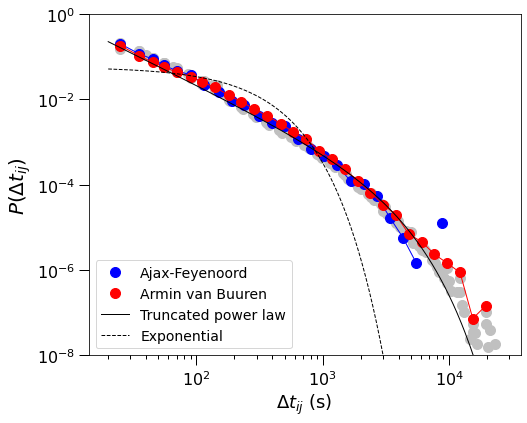

In [23]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15,top=0.95,bottom=0.16)

for i in range(5):
    plt.loglog(bin_centers_1[i], hist_1[i], 'o', color='silver', markersize=10)

plt.loglog(bin_centers1a, hist1a, 'bo', markersize=10, label='Ajax-Feyenoord')
plt.loglog(bin_centers1a, hist1a, 'b', linewidth=1)

plt.loglog(bin_centers2a, hist2a, 'o', color='red', markersize=10, label='Armin van Buuren')
plt.loglog(bin_centers2a, hist2a, color='red', linewidth=1)

# temporary solution
#fit.stretched_exponential.plot_pdf(color = 'k', linewidth =2)
plt.loglog(t1, tlf1, color='k', linewidth=1, label='Truncated power law') 

plt.loglog(t_exp1, exp1, color='k', linewidth=1, linestyle='dashed', label='Exponential')   

plt.xlabel(r'$\Delta t_{ij}$' + ' (s)', fontsize=18)
plt.ylabel(r'$P(\Delta t_{ij})$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(axis='both',length=10,width=1,which='major')
plt.tick_params(axis='both',length=4,width=1,which='minor')

plt.legend(loc=3,fontsize = 14)
#plt.xlim([10,1e5])
plt.ylim([1e-8,1])

#plt.savefig('plots/contactduration-pdfs-combi-20220612.png')

plt.show()

In [24]:
#np.savetxt('contactdurations2.txt', contactdurations2, delimiter=' ')

In [25]:
weights2=np.array(weights2)

In [26]:
fit = powerlaw.Fit(weights2, xmin=min(weights2))
fit.truncated_power_law.alpha

/opt/anaconda3/envs/phdenv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


1.6249987763350475

In [27]:
lambda_tlf = fit.truncated_power_law.Lambda
alpha = fit.truncated_power_law.alpha
a = fit.power_law.xmin

In [28]:
t2 = np.sort(weights2)
t_exp2 = np.sort(weights2)

In [29]:
# TLF
C = lambda_tlf**(1-alpha) / float(gammainc(1-alpha,lambda_tlf*2))
tlf2 = C * t2**(-alpha) * np.exp(-lambda_tlf*t2)

In [30]:
scaling = len(weights2[weights2 > a]) / len(weights2)
tlf2*=scaling

In [31]:
lambda_exp = 0.036674788047543844

In [32]:
# Exponential
a = min(weights2)
exp2 = lambda_exp * np.exp(-lambda_exp * (t_exp2 - a))

In [33]:
t2*=10
t_exp2*=10

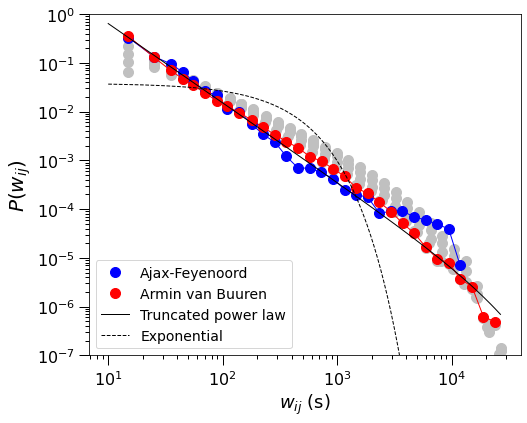

In [34]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15,top=0.95,bottom=0.16)

for i in range(5):
    plt.loglog(bin_centers_2[i], hist_2[i], 'o', color='silver', markersize=10)

plt.loglog(bin_centers1b, hist1b, 'bo', markersize=10, label='Ajax-Feyenoord')
plt.loglog(bin_centers1b, hist1b, 'b', linewidth=1)

plt.loglog(bin_centers2b, hist2b, 'o', color='red', markersize=10, label='Armin van Buuren')
plt.loglog(bin_centers2b, hist2b, color='red', linewidth=1)

# temporary solution
#fit.stretched_exponential.plot_pdf(color = 'k', linewidth =2)
plt.loglog(t2, tlf2, color='k', linewidth=1, label='Truncated power law') 

plt.loglog(t_exp2, exp2, color='k', linewidth=1, linestyle='dashed', label='Exponential')   

plt.xlabel(r'$w_{ij}$' + ' (s)', fontsize=18)
plt.ylabel(r'$P(w_{ij})$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(axis='both',length=10,width=1,which='major')
plt.tick_params(axis='both',length=4,width=1,which='minor')

plt.legend(loc=3,fontsize = 14)
#plt.xlim([10,1e5])
plt.ylim([1e-7,1])

#plt.savefig('plots/weight-distributions-combi-20220612.png')

plt.show()

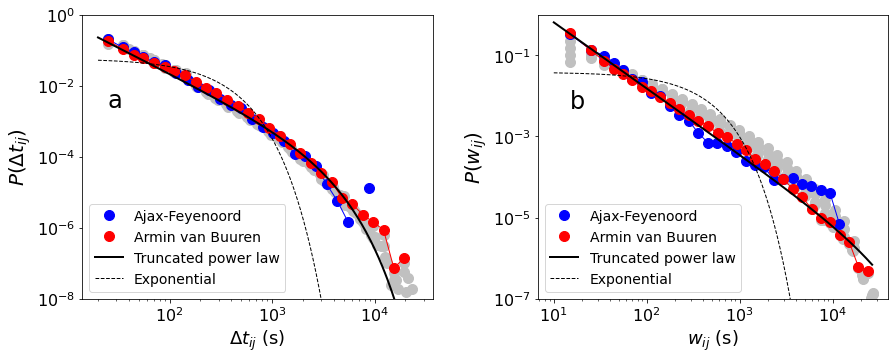

In [35]:
fig = plt.figure(figsize=(14,5))
grid = plt.GridSpec(1,2,left=0.1,top=0.95,wspace=0.3,bottom=0.16)
# left=0.1, bottom=0.05, right=None, top=0.95, hspace=0.4, wspace=0.4
p0=fig.add_subplot(grid[0,0])

s=14

## -------------------------------------------------------------------------

for i in range(5):
    plt.loglog(bin_centers_1[i], hist_1[i], 'o', color='silver', markersize=10)

plt.loglog(bin_centers1a, hist1a, 'bo', markersize=10, label='Ajax-Feyenoord')
plt.loglog(bin_centers1a, hist1a, 'b', linewidth=1)

plt.loglog(bin_centers2a, hist2a, 'o', color='red', markersize=10, label='Armin van Buuren')
plt.loglog(bin_centers2a, hist2a, color='red', linewidth=1)

plt.loglog(t1, tlf1, color='k', linewidth=2, label='Truncated power law') 

plt.loglog(t_exp1, exp1, color='k', linewidth=1, linestyle='dashed', label='Exponential')

p0.set_xlabel(r'$\Delta t_{ij}$' + ' (s)', fontsize=18)
p0.set_ylabel(r'$P(\Delta t_{ij})$', fontsize=20)
plt.setp(p0.get_xticklabels(), fontsize=16)
plt.setp(p0.get_yticklabels(), fontsize=16)
#plt.tick_params(axis='both',length=10,width=1,which='major')
#plt.tick_params(axis='both',length=4,width=1,which='minor')
p0.text(25, 2.5e-3, 'a', fontsize=24)
p0.legend(loc=3,fontsize=14)

p0.set_ylim([1e-8,1])

plt.legend(loc=3,fontsize = 14)


## -------------------------------------------------------------------------
p1=fig.add_subplot(grid[0,1])

for i in range(5):
    plt.loglog(bin_centers_2[i], hist_2[i], 'o', color='silver', markersize=10)

plt.loglog(bin_centers1b, hist1b, 'bo', markersize=10, label='Ajax-Feyenoord')
plt.loglog(bin_centers1b, hist1b, 'b', linewidth=1)

plt.loglog(bin_centers2b, hist2b, 'o', color='red', markersize=10, label='Armin van Buuren')
plt.loglog(bin_centers2b, hist2b, color='red', linewidth=1)

plt.loglog(t2, tlf2, color='k', linewidth=2, label='Truncated power law') 

plt.loglog(t_exp2, exp2, color='k', linewidth=1, linestyle='dashed', label='Exponential')


p1.set_xlabel(r'$w_{ij}$' + ' (s)', fontsize=18)
p1.set_ylabel(r'$P(w_{ij})$', fontsize=20)
p1.tick_params(labelsize=16)
plt.yticks(fontsize=16)
p1.text(15, 5e-3, 'b', fontsize=24)
p1.legend(fontsize=14, loc=3)

p1.set_ylim([1e-7,1])

#plt.savefig('Figure05.eps')

plt.show()

In [36]:
def getDegrees(df):
    nodepairlist={'Source': [],
             'Target': []}
    for node, group in df.groupby(['Source','Target']):
        nodepairlist['Source'].append(node[0])
        nodepairlist['Target'].append(node[1])
    dfnet=pd.DataFrame(nodepairlist)
    
    ## Create degree list
    nodes=np.concatenate((dfnet['Source'].values,dfnet['Target'].values))
    print(min(np.unique(nodes)), max(np.unique(nodes)))
    degrees=[]
    for v in np.unique(nodes): # dfnet['Source'].unique(),dfnet['Target'].unique()
        degrees.append(len(np.where(nodes == v)[0]))
        
    return degrees

In [37]:
degrees1 = getDegrees(df1)
degrees2 = getDegrees(df2)

0 361
0 1047


In [38]:
hist1, bin_edges = np.histogram(degrees1, bins=20, density=True)
bin_centers1 = (bin_edges[1:]+bin_edges[:-1])/2.0
hist2, bin_edges = np.histogram(degrees2, bins=20, density=True)
bin_centers2 = (bin_edges[1:]+bin_edges[:-1])/2.0

In [39]:
mu1=np.mean(degrees1)
k1=np.arange(np.max(degrees1))
p_1 = poisson.pmf(k1, mu1)
mu2=np.mean(degrees2)
k2=np.arange(np.max(degrees2))
p_2 = poisson.pmf(k2, mu2)

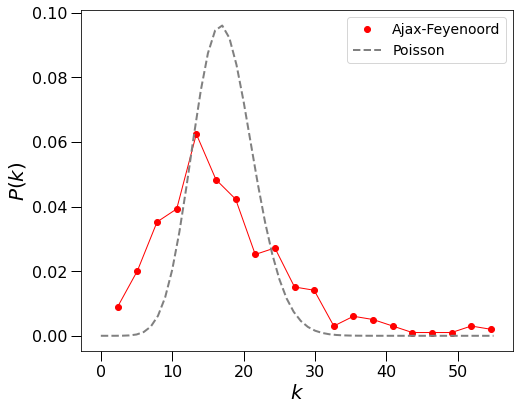

In [40]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15,top=0.95,bottom=0.16)

plt.plot(bin_centers1, hist1, 'ro', label='Ajax-Feyenoord')
plt.plot(bin_centers1, hist1, color='r', linewidth=1)

plt.plot(k1, p_1, linestyle='--', color='grey', linewidth=2, label='Poisson')

plt.xlabel(r'$k$', fontsize=20)
plt.ylabel(r'$P(k)$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(axis='both',length=10,width=1,which='major')
plt.tick_params(axis='both',length=4,width=1,which='minor')

plt.legend(loc=1,fontsize = 14)
#plt.legend()

#plt.savefig('degree-distribution-ajax-poisson-fit-20210519.png')
plt.show()

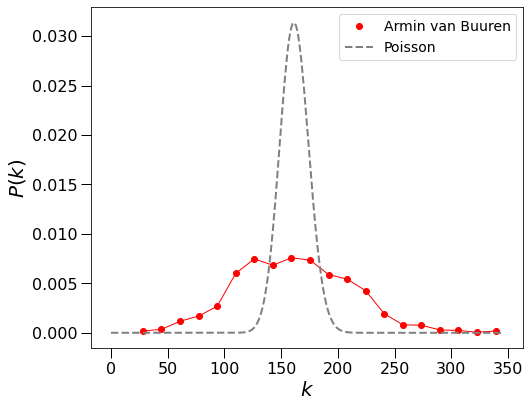

In [41]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15,top=0.95,bottom=0.16)

plt.plot(bin_centers2, hist2, 'ro', label='Armin van Buuren')
plt.plot(bin_centers2, hist2, color='r', linewidth=1)

plt.plot(k2, p_2, linestyle='--', color='grey', linewidth=2, label='Poisson')

plt.xlabel(r'$k$', fontsize=20)
plt.ylabel(r'$P(k)$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(axis='both',length=10,width=1,which='major')
plt.tick_params(axis='both',length=4,width=1,which='minor')

plt.legend(loc=1,fontsize = 14)

#plt.savefig('degree-distribution-armin-poisson-fit-20210519.png')
plt.show()

## Sweep degree distributions over distance threshold

In [42]:
histograms1=[]
for i in range(10):
    filename='Cpp/contactsequence362a_sweep' + str(i) + '.csv'
    df11=pd.read_csv(filename,header=None,names=['Source','Target','timestamp'])
    degrees11 = getDegrees(df11)
    hist11, bin_edges = np.histogram(degrees11, bins=20, density=True)
    bin_centers11 = (bin_edges[1:]+bin_edges[:-1])/2.0
    histograms1.append([bin_centers11, hist11])

0 361
0 361
0 361
0 361
0 361
0 361
0 361
0 361
0 361
0 361


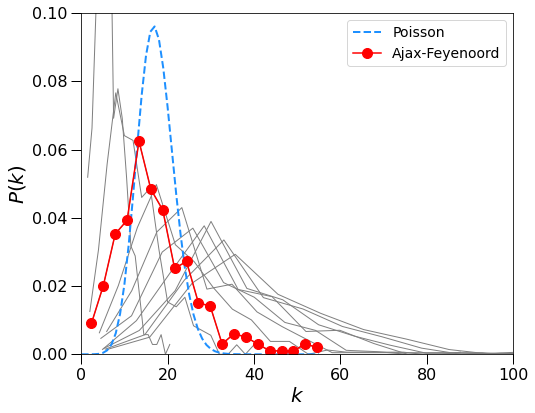

In [43]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15,top=0.95,bottom=0.16)

for i in range(0,10):
    #plt.plot(histograms[i][0], histograms[i][1], 'o', color='grey')
    plt.plot(histograms1[i][0], histograms1[i][1], color='grey', linewidth=1)

plt.plot(k1, p_1, linestyle='--', color='dodgerblue', linewidth=2, label='Poisson')

plt.plot(bin_centers1, hist1, color='r',marker='o', markersize=10, label='Ajax-Feyenoord')

plt.xlabel(r'$k$', fontsize=20)
plt.ylabel(r'$P(k)$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(axis='both',length=10,width=1,which='major')
plt.tick_params(axis='both',length=4,width=1,which='minor')
plt.xlim([0,100])
plt.ylim([0,0.1])

plt.legend(loc=1,fontsize = 14)
#plt.legend()

#plt.savefig('degree-distribution-ajax-poisson-fit-20211006.png')
plt.show()

In [44]:
histograms2=[]
for i in range(10):
    filename='contactsequence1048_sweep' + str(i) + '.csv'
    df21=pd.read_csv(filename,header=None,names=['Source','Target','timestamp'])
    degrees21 = getDegrees(df21)
    hist21, bin_edges = np.histogram(degrees21, bins=20, density=True)
    bin_centers21 = (bin_edges[1:]+bin_edges[:-1])/2.0
    histograms2.append([bin_centers21, hist21])

0 1047
0 1047
0 1047
0 1047
0 1047
0 1047
0 1047
0 1047
0 1047
0 1047


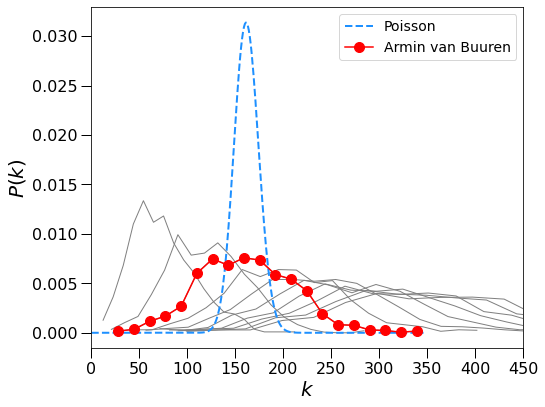

In [45]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15,top=0.95,bottom=0.16)

for i in range(0,10):
    #plt.plot(histograms[i][0], histograms[i][1], 'o', color='grey')
    plt.plot(histograms2[i][0], histograms2[i][1], color='grey', linewidth=1)
    
plt.plot(k2, p_2, linestyle='--', color='dodgerblue', linewidth=2, label='Poisson')

plt.plot(bin_centers2, hist2, color='r',marker='o', markersize=10, label='Armin van Buuren')

plt.xlabel(r'$k$', fontsize=20)
plt.ylabel(r'$P(k)$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(axis='both',length=10,width=1,which='major')
plt.tick_params(axis='both',length=4,width=1,which='minor')
plt.xlim([0,450])
#plt.ylim([0,0.1])

plt.legend(loc=1,fontsize = 14)
#plt.legend()

#plt.savefig('degree-distribution-armin-poisson-fit-20211006.png')
plt.show()

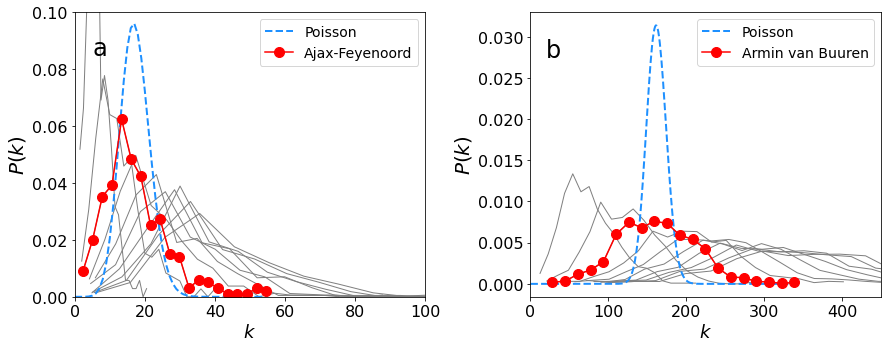

In [46]:
fig = plt.figure(figsize=(14,5))
grid = plt.GridSpec(1,2,left=0.1,top=0.95,wspace=0.3,bottom=0.16)
# left=0.1, bottom=0.05, right=None, top=0.95, hspace=0.4, wspace=0.4
p0=fig.add_subplot(grid[0,0])

s=14

## -------------------------------------------------------------------------

for i in range(0,10):
    plt.plot(histograms1[i][0], histograms1[i][1], color='grey', linewidth=1)

p0.plot(k1, p_1, linestyle='--', color='dodgerblue', linewidth=2, label='Poisson')

p0.plot(bin_centers1, hist1, color='r',marker='o', markersize=10, label='Ajax-Feyenoord')

p0.set_xlabel(r'$k$', fontsize=18)
p0.set_ylabel(r'$P(k)$', fontsize=20)
plt.setp(p0.get_xticklabels(), fontsize=16)
plt.setp(p0.get_yticklabels(), fontsize=16)
#plt.tick_params(axis='both',length=10,width=1,which='major')
#plt.tick_params(axis='both',length=4,width=1,which='minor')
p0.text(5, 0.085, 'a', fontsize=24)
p0.legend(loc=1,fontsize=14)
p0.set_xlim([0,100])
p0.set_ylim([0,0.1])

## -------------------------------------------------------------------------
p1=fig.add_subplot(grid[0,1])

for i in range(0,10):
    plt.plot(histograms2[i][0], histograms2[i][1], color='grey', linewidth=1)
    
p1.plot(k2, p_2, linestyle='--', color='dodgerblue', linewidth=2, label='Poisson')

p1.plot(bin_centers2, hist2, color='r',marker='o', markersize=10, label='Armin van Buuren')

p1.set_xlabel(r'$k$', fontsize=18)
p1.set_ylabel(r'$P(k)$', fontsize=20)
p1.tick_params(labelsize=16)
plt.yticks(fontsize=16)
p1.text(20, 0.0275, 'b', fontsize=24)
p1.legend(fontsize=14, loc=1)
p1.set_xlim([0,450])


#plt.savefig('Figure04.eps')

plt.show()

## Compare to random graph

In [47]:
N1 = 362
N2 = 1048
p1=mu1/(N1-1)
p2=mu2/(N2-1)

In [48]:
L1=[]
L2=[]
C1=[]
C2=[]
for i in range(20):
    G1 = nx.erdos_renyi_graph(N1, p1, seed=None, directed=False)
    G2 = nx.erdos_renyi_graph(N2, p2, seed=None, directed=False)
    L1.append(nx.average_shortest_path_length(G1))
    L2.append(nx.average_shortest_path_length(G2))
    C1.append(nx.average_clustering(G1))
    C2.append(nx.average_clustering(G2))
print("Average path length (Ajax-Feyenoord):", np.mean(L1))
print("Average path length (Armin van Buuren):", np.mean(L2))
print("Clustering coefficient (Ajax-Feyenoord):", np.mean(C1))
print("Clustering coefficient (Armin van Buuren):", np.mean(C2))

Average path length (Ajax-Feyenoord): 2.370815414517684
Average path length (Armin van Buuren): 1.845692436404996
Clustering coefficient (Ajax-Feyenoord): 0.04870074605440824
Clustering coefficient (Armin van Buuren): 0.15430605747153797
